# Week 1 — Data Features with APIs: Spotify Wordcloud Generator

This program is a simple data feature prototype that generates a Word Cloud based on the lyrics of a user's Spotify playlist.

The project demonstrates how to combine data from multiple APIs and use text processing techniques to create a cool visual to use for the playlist's cover.


We used three main components:
1.   The Spotify API to retrieve data (i.e. tracks) from a Spotify profile
2.   The Genius API to retrieve lyrics for those tracks
3.   Matplotlib's Word cloud generator to create a visual representation of the most common words in these lyrics

### Install necessary libraries

In [75]:
# Google Colab specific imports
from google.colab import userdata # for setting up the API keys
from google.colab import auth
from google.colab import output

# Web and API related imports
import webbrowser
import requests
!pip install lyricsgenius
import lyricsgenius # genius API

# Data visualization imports
from IPython.display import display, HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Data processing and analysis imports
from collections import Counter
import re

# Natural Language Processing imports
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Set up the API keys

The API keys are stored in the SECRETS tab on the left (key icon) and named like the variables provided below.

In [76]:
# Retrieve Irfan's Spotify API key from secrets
CLIENT_ID = userdata.get('CLIENT_ID_irfan')
CLIENT_SECRET = userdata.get('CLIENT_SECRET_irfan')
REDIRECT_URI = userdata.get('REDIRECT_URI_irfan')

In [ ]:
# Retrieve Nadia's Spotify API key from secrets
CLIENT_ID = userdata.get('CLIENT_ID_nadia')
CLIENT_SECRET = userdata.get('CLIENT_SECRET_nadia')
REDIRECT_URI = userdata.get('REDIRECT_URI_nadia')

In [77]:
#genius_token = GENIUS_ACCESS_TOKEN
GENIUS_ACCESS_TOKEN = userdata.get('GENIUS_ACCESS_TOKEN')

In [78]:
# Print confirmation messages for API keys (without revealing the actual keys)

if all([CLIENT_ID, CLIENT_SECRET, REDIRECT_URI]):
    print("All Spotify API keys and credentials retrieved successfully!")
else:
    print("Failed to retrieve one or more API keys. Please check your setup.")

if GENIUS_ACCESS_TOKEN:
    print("Genius API key is also set!")
else:
    print("Failed to set Genius API key. Please check your setup.")

# Request scopes for reading playlists and saved tracks
SCOPE = 'playlist-read-private user-library-read'

All Spotify API keys and credentials retrieved successfully!
Genius API key is also set!


Step 1: Authorize Spotify user

In [79]:
# Generate the authorization URL
auth_url = f"https://accounts.spotify.com/authorize?response_type=code&client_id={CLIENT_ID}&redirect_uri={REDIRECT_URI}&scope={SCOPE}"

# Display the URL for the user to click
print("Please click on this URL to authorize the application:")
display(HTML(f'<a href="{auth_url}" target="_blank">{auth_url}</a>'))

# Ask user to paste the authorization code manually from the browser
authorization_code = input("After authorizing, paste the auth (i.e. everything in the uri after the 'code=')")


Please click on this URL to authorize the application:


After authorizing, paste the auth (i.e. everything in the uri after the 'code=')AQBgRK7poc9FCnjtkh_OVrt1XX6yl_7xUWmotyoZ5PbTBIsK1gTkPjYeTlBlsLUtLYRbQYuYkGVMdgI9w9g3TvKPV9rf0amhC8zQYRn92Td0eEKH54uQsKdvxnR8n1SvCt_c9sKio0GUis9nFuLR2hriS8uoWWG2c1AU-r-cL7W5iJ0Z8R7TEjvn3HaPgyuUiCP49feuhr_6s1R0X8niWu-nv46dQfwW7seSeFq5Fgzm54YS9poi


Step 2: Exchange authorization code for access token

In [80]:
def get_access_token(auth_code):
    url = 'https://accounts.spotify.com/api/token'
    data = {
        'grant_type': 'authorization_code',
        'code': auth_code,
        'redirect_uri': REDIRECT_URI,
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET
    }

    response = requests.post(url, data=data)
    return response.json()

# Exchange the authorization code for an access token
auth_response_data = get_access_token(authorization_code)

# Extract the access token from the response
if 'access_token' in auth_response_data:
    access_token = auth_response_data['access_token']  # Fix here to extract the token
    print("Access token retrieved successfully.")
else:
    print("Error retrieving access token.")
    print(auth_response_data)

Access token retrieved successfully.


Step 3: Function definition that Fetchs user's playlists

In [81]:
def get_user_playlists(access_token, limit=1):
    playlists_url = "https://api.spotify.com/v1/me/playlists"
    headers = {
        "Authorization": f"Bearer {access_token}"  # Corrected to use only the token
    }
    params = {
        "limit": limit
    }

    response = requests.get(playlists_url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Error getting playlists: {response.status_code} - {response.json()}")
        return None

    return response.json()

Step 4: Fetch tracks from a specific playlist

In [82]:
def get_playlist_tracks(access_token, playlist_id):
    tracks_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = {
        "Authorization": f"Bearer {access_token}"  # Corrected to use only the token
    }
    params = {
        "fields": "items(track(name,artists(name)))"
    }

    response = requests.get(tracks_url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Error getting tracks: {response.status_code} - {response.json()}")
        return None

    return response.json()

Step 5: Function to Fetch lyrics from Genius API

In [83]:
def get_lyrics(song_title, artist_name, genius_token):
    genius = lyricsgenius.Genius(genius_token)

    try:
        song = genius.search_song(song_title, artist_name)
        if song:
            return song.lyrics
        else:
            return f"Lyrics not found for {song_title} by {artist_name}"
    except Exception as e:
        return f"Error fetching lyrics: {str(e)}"

genius_token = GENIUS_ACCESS_TOKEN

Step 6: Function to generate the Word Cloud

In [ ]:
def generate_word_cloud(lyrics_list, playlist_name):
    # Combine all lyrics into a single string
    all_text = ' '.join(lyrics_list)

    # Clean the text
    cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in cleaned_text.split() if word not in stop_words]

    # Count word frequencies
    word_freq = Counter(words)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Playlist: {playlist_name}")
    plt.show()

    # Save the word cloud as an image
    wordcloud.to_file(f"{playlist_name}_wordcloud.png")
    print(f"Word cloud saved as {playlist_name}_wordcloud.png")

Step 7: Generating the word cloud using all our functions

Streaming output truncated to the last 5000 lines.
​seasonal depression - mxmtoon
​seeking peace - Towerz & hi jude
See You Again - Tyler, The Creator feat. Kali Uchis
Self Destruction - WESTSIDE BOOGIE
Selfish - Indii G. & SadBoyProlific
Selfish - SAINt JHN
Señorita - Vince Staples
Separate from You - sadgods feat. Powfu & Indii G
Sept. 16 - Kid Cudi
Seven Letters - The Underachievers feat. KingJet
​sex - EDEN
Sex Sells - Lovejoy
Shabba - A$AP Ferg feat. A$AP Rocky
Shades of Us - Quadeca
​shadow - guardin
Shadowboxin' - GZA feat. Method Man
Shakey Dog - Ghostface Killah
Shame - Freddie Gibbs & Madlib
Shameless - iann dior
Shawshank - Denzel Curry feat. Tate Kobang
SHELF - 1 800 PAIN
She Plays Bass - beabadoobee
She's So Nice - Pink Guy
​shift invariant - Bonjr & singular balance
Shitsville - Freddie Gibbs & Madlib
Shook Ones, Pt. II - Mobb Deep
Shoota - Playboi Carti feat. Lil Uzi Vert
Shoot Me Down - Lil Wayne feat. D. Smith
Shootouts - Nas
​short kings anthem - blackbear & Tiny Meat

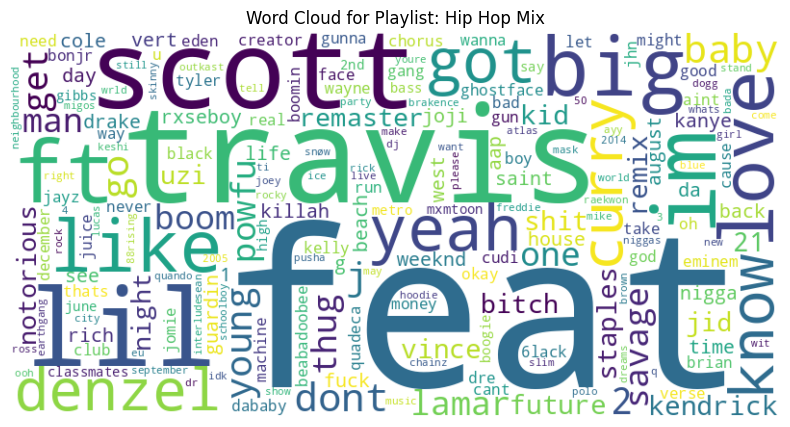

Word cloud saved as Hip Hop Mix_wordcloud.png


In [84]:
def get_particular_playlist_tracks(access_token):
    # Get the first playlist
    playlists_data = get_user_playlists(access_token, limit=50)
    print(playlists_data)

    all_lyrics = []

    if not playlists_data or not playlists_data.get("items"):
        print("No playlists found")
        return
    for item in playlists_data["items"]:
      print(item["name"])

    first_playlist = playlists_data["items"][28]
    playlist_id = first_playlist["id"]
    playlist_name = first_playlist["name"]

    tracks_data = get_playlist_tracks(access_token, playlist_id)

    if not tracks_data or not tracks_data.get("items"):
        print(f"No tracks found in playlist '{playlist_name}'")
        return

    print(f"Tracks in playlist '{playlist_name}':")
    for item in tracks_data["items"]:
        track = item["track"]
        artists = ", ".join([artist["name"] for artist in track["artists"]])
        print(f"- {track['name']} by {artists}")
        lyrics = get_lyrics(track['name'], artists, genius_token)
        print(lyrics)

        if lyrics:
            all_lyrics.append(lyrics)

        # Generate word cloud
    generate_word_cloud(all_lyrics, playlist_name)

get_particular_playlist_tracks(access_token)